# Notebook: Predicting Behaviour

## Overview

**This notebook extends the predicting behaviour model described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943)**

---
## Data

**Data provided is already preprocessed but needs to be converted in model usabale format**

In [32]:
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler

In [33]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)
print(TS.keys())

dict_keys(['testretest', 'twomen', 'bridgeville', 'pockets', 'overcome', 'inception', 'socialnet', 'oceans', 'flower', 'hotel', 'garden', 'dreary', 'homealone', 'brokovich', 'starwars'])


In [34]:
for movie_name, ts in TS.items():
    print(ts.shape)

(4, 176, 84, 300)
(176, 245, 300)
(176, 222, 300)
(176, 189, 300)
(176, 65, 300)
(176, 227, 300)
(176, 260, 300)
(176, 250, 300)
(176, 181, 300)
(176, 186, 300)
(176, 205, 300)
(176, 143, 300)
(176, 233, 300)
(176, 231, 300)
(176, 256, 300)


### Behavioural Scores Normalization

In [35]:
with open('HCP_behavioral_scores.pkl','rb') as f:
    TS1 = pickle.load(f)
    print(TS1.keys())

Index(['Subject', 'PMAT24_A_CR', 'PicVocab_Unadj', 'NEOFAC_A', 'NEOFAC_O',
       'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E'],
      dtype='object')


In [36]:
scaler = MinMaxScaler()
dict_ = {}
for col,ts in TS1.items():
    k = scaler.fit_transform(np.array(ts).reshape((-1,1))).reshape((-1,))
    dict_[col] = k

df = pd.DataFrame.from_dict(dict_)
df

,Subject,PMAT24_A_CR,PicVocab_Unadj,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,0.000000,1.000000,0.851851,0.375000,0.620690,0.612903,0.135135,0.000000
1,0.001901,0.823529,0.438968,0.291667,0.655172,0.677419,0.432432,0.387097
2,0.002466,0.647059,0.141904,0.583333,0.413793,0.483871,0.216216,0.516129
3,0.004255,1.000000,0.574822,0.708333,0.655172,0.903226,0.189189,0.322581
4,0.005939,0.941176,0.411379,0.375000,0.517241,0.419355,0.243243,0.548387
...,...,...,...,...,...,...,...,...
171,0.951130,0.411765,0.354675,0.708333,0.586207,0.741935,0.405405,0.774194
172,0.959536,0.470588,0.490631,0.500000,0.482759,0.161290,0.540541,0.193548
173,0.968477,0.470588,0.134435,0.458333,0.344828,0.612903,0.540541,0.548387
174,0.973156,0.647059,0.681923,0.416667,0.724138,0.645161,0.756757,0.612903


## Dataset organization
`TS` is a dictionary with movie names as keys

Value against each key is a numpy array of dimensions `[#participants, #time points, #ROIs]`

Note that the testretest movie appears on all 4 runs for a participant, therefore the value has dimensions `[#runs, #participants, #time points, #ROIs]`

In [37]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import random
def get_data(behav_score , movie, seq_length,shuffle=False):
    rel = {}
    l  = 1
    for score in df[behav_score]:
        rel[l] = score 
        l += 1
    
    train_feature = []
    test_feature  = []
    train_target  = []
    test_target   = []
    for movie_name, ts in TS.items():
        pep = 0
        if movie_name == movie:
            for i in ts:
                pep += 1
                if (pep <= 100):
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        train_feature.append(k)
                        train_target.append([rel[pep]])

                        k = i[i.shape[0]-seq_length:][:]
                        train_feature.append(k)
                        train_target.append([rel[pep]])

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        train_feature.append(k)
                        train_target.append([rel[pep]])
                    else:
                        if shuffle:
                            np.random.shuffle(i)
                            train_feature.append(i)
                        else:
                            train_feature.append(i)
                        train_target.append([rel[pep]]*seq_length)

                else:
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        test_feature.append(k)
                        test_target.append([rel[pep]]*seq_length)

                        k = i[i.shape[0]-seq_length:][:]
                        test_feature.append(k)
                        test_target.append([rel[pep]]*seq_length)

                    elif i.shape[0]<seq_length:
                        k = [[0]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        test_feature.append(k)
                        test_target.append([rel[pep]]*seq_length)
                    else:
                        test_feature.append(i)
                        test_target.append([rel[pep]]*seq_length)
            print(pep)
        '''else:
            for jj in ts:
                pep = 0
                for i in jj:
                    pep += 1
                    if (pep <= 100):
                        if i.shape[0]>seq_length:
                            k = i[:seq_length][:]
                            train_feature.append(k)
                            train_target.append(rel[pep])

                            k = i[i.shape[0]-seq_length:][:]
                            train_feature.append(k)
                            train_target.append(rel[pep])

                        elif i.shape[0]<seq_length:
                            k = [[0]*300]*seq_length
                            k[seq_length-i.shape[0]:] = i
                            train_feature.append(k)
                            train_target.append(rel[pep])
                        else:
                            train_feature.append(i)
                            train_target.append(rel[pep])

                    else:
                        if i.shape[0]>seq_length:
                            k = i[:seq_length][:]
                            test_feature.append(k)
                            test_target.append(rel[pep])

                            k = i[i.shape[0]-seq_length:][:]
                            test_feature.append(k)
                            test_target.append(rel[pep])

                        elif i.shape[0]<seq_length:
                            k = [[0]*300]*seq_length
                            k[seq_length-i.shape[0]:] = i
                            test_feature.append(k)
                            test_target.append(rel[pep])
                        else:
                            test_feature.append(i)
                            test_target.append(rel[pep])
                print(pep)'''
    
    train_data = TensorDataset(torch.from_numpy(np.array(train_feature)).float(),torch.from_numpy(np.array(train_target)).float())
    test_data  = TensorDataset(torch.from_numpy(np.array(test_feature)).float(),torch.from_numpy(np.array(test_target)).float())
    
    
    batch_size  = 15
    valid_data  = 0.30
    t_train     = len(train_data)
    data_no     = list(range(t_train))
    np.random.shuffle(data_no)
    split_no    = int(np.ceil(valid_data*t_train))
    train,valid = data_no[split_no:] + data_no[:5],data_no[:split_no]

    train_sampler = SubsetRandomSampler(train)
    valid_sampler = SubsetRandomSampler(valid)

    train_loader  = DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
    valid_loader  = DataLoader(train_data,sampler=valid_sampler,batch_size=batch_size)
    test_loader   = DataLoader(test_data, batch_size=batch_size)#,shuffle = True)
    return train_loader,valid_loader,test_loader

## Training, Validation, Test

With the data in required shape, The following shows the split into training, validation, and test sets.

In [38]:
batch_size  = 15
shuffle = False
cols = ['PMAT24_A_CR','PicVocab_Unadj','NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_E']
mov = ['testretest', 'twomen', 'bridgeville', 'pockets', 'overcome', 'inception', 'socialnet', 'oceans', 'flower', 'hotel', 'garden', 'dreary', 'homealone', 'brokovich', 'starwars']
movie = 'starwars'
seq_length  = TS[movie].shape[1]
score = cols[0]#'PMAT24_A_CR'

train_loader,valid_loader,test_loader = get_data(score,movie,seq_length,shuffle)

176


In [39]:
len(train_loader),len(valid_loader),len(test_loader)

(5, 2, 6)

In [40]:
iter(train_loader).next()[0].shape

torch.Size([15, 256, 300])

In [41]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Models

### Implementing the `Attention` Model

The following figures shows the idea behind it


<img src="attntion1.png" align="center">

In [42]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, seq_len, bias=False, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True
        self.bias       = bias
        self.hidden_dim = hidden_dim
        self.seq_len    = seq_len
        
        weight = torch.zeros(hidden_dim, 1)
        nn.init.kaiming_uniform_(weight)
        
        context = torch.zeros(seq_len,seq_len)
        nn.init.kaiming_uniform_(context)
        
        self.context = nn.Parameter(context)
        self.weight  = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(seq_len))
        
    def forward(self, x,mask=None):
        #print(x.shape,x.contiguous().view(-1, self.hidden_dim).shape)
        eij = torch.mm(x.contiguous().view(-1, self.hidden_dim ), self.weight).view(-1,self.seq_len)
        if self.bias:
            eij = eij + self.b    
        eij = torch.tanh(eij)
        #print(eij.shape)
        eij = torch.mm(eij,self.context)
        #eij = torch.nn.functional.normalize(eij,p=2.5,dim=1)
        a = torch.exp(eij)
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)
        weighted_input = x * torch.unsqueeze(a, -1)
        #weighted_input = torch.nn.functional.normalize(weighted_input,p=2.5,dim=0)
        #x = torch.sum(weighted_input, 2)
        #x = x.view(batch_size,seq_length,1)
        #print(torch.sum(weighted_input, 2).eq(weighted_input))
        return weighted_input

### `GRU Classifier` Model as described in the [paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008943)
<img src="gru.png">

In [43]:
class GRU_RNN(nn.Module):

    def __init__(self, input_dim, output_dim,hidden_dim,seq_length,n_layers,att=True,drop_prob=0.000001):
        super(GRU_RNN, self).__init__()

        self.output_dim = output_dim
        self.n_layers   = n_layers
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.att        = att
        
        self.gru       = nn.GRU(input_dim,hidden_dim,num_layers=n_layers,dropout=drop_prob,batch_first=True)
        self.linear    = nn.Linear(hidden_dim,output_dim)
        if att:
            self.attention = Attention(hidden_dim,seq_length)
        
        self.dropout   = nn.Dropout(0.3)
        self.func      = nn.Softmax(dim = -1)

    def forward(self, x, hidden,encoder_x=0):
        x,hidden = self.gru(x,hidden)
        if self.att:
            x = self.attention(x)
        else:
            x = x#[:, -1, :]
        #x = self.dropout(x)
        x = self.linear(x)
        sig_out = x#self.func(x)
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

## Training

In [44]:
def train(epochs,train_loader,net,valid_loader,optimzer,criterion,att=True):
    val_acc = []
    tr_acc = []
    
    clip = 4 # gradient clipping

    net.to(device)
    net.train()
    
    valid_loss_min = np.Inf 
    
    valid_losses = []
    train_losses = []
    
    for e in range(epochs):
        num_correct = 0
        h = net.init_hidden(batch_size)
        train_loss = []
        valid_loss = []
        train_acc  = 0.0
        valid_acc  = 0.0 
        counter = 0
        for inputs, labels in train_loader:
            top_value = 0
            counter += 1
            #if counter == 65:
            #    continue
            #print(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            #print(labels)
            h = h.data
            net.zero_grad()

            output, h = net(inputs, h)
            #output = output[:, -1, :]
            output = output.view(batch_size,-1)
            #print(output.shape,labels.shape)#view(batch_size,-1)
            
            #print(output[0])
            #break
            #pred = output#torch.round(output.squeeze()) 
            #print(pred)
            #top_value, top_index = torch.max(output,1)
            #print(top_value)
            #print(labels.shape)
            #print(top_value, top_index)
            correct_tensor = output.eq(labels.float())#.view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)

            loss = criterion(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            train_loss.append(loss.item())
        tr_acc.append(num_correct/((len(train_loader)-1)*batch_size))



        acc = 0.0
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        num_correct = 0
        v_c = 0
        for inputs, labels in valid_loader:
            top_value = 0
            v_c += 1
            if v_c==2:
                continue
            val_h = val_h.data
            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = net(inputs, val_h)
            
            #pred = torch.round(output.squeeze()) 
            #print(pred)
            #top_value, top_index = torch.max(output,1)
            output = output.view(batch_size,-1)
            #output = output[:, -1, :]
            #print(top_value.squeeze().shape,labels.shape)
            correct_tensor = output.eq(labels.float())#.view_as(top_index))
            correct = np.squeeze(correct_tensor.to('cpu').numpy())
            num_correct += np.sum(correct)

            val_loss = criterion(output,labels)
            val_losses.append(val_loss.item())
            
            if val_loss.item() <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss.item()))
                best_epoch = e
                if att:
                    torch.save(net.state_dict(), 'RNN_GRU_Att.pt')
                else:
                    torch.save(net.state_dict(), 'RNN_GRU.pt')
                valid_loss_min = val_loss.item()

        net.train()
        valid_losses.append(np.mean(val_losses))
        train_losses.append(np.mean(train_loss))
        val_acc.append(num_correct/(len(valid_loader)*batch_size))
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,epochs,np.mean(train_loss),np.mean(val_losses)))
    return train_losses,valid_losses,tr_acc,val_acc,best_epoch

In [45]:
epochs     = 50
input_dim  = 300
hidden_dim = 32
output_dim = 1
n_layers   = 2
lr         = 0.001

### Training with Attention Layer

In [46]:
model       = GRU_RNN(input_dim, output_dim, hidden_dim, seq_length, n_layers)
optimizer   = torch.optim.Adam(model.parameters(), lr=lr)
criterion   = torch.nn.MSELoss()#nn.CrossEntropyLoss()
print(model)

GRU_RNN(
  (gru): GRU(300, 32, num_layers=2, batch_first=True, dropout=1e-06)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (attention): Attention()
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [47]:
train_losses,valid_losses,tr_acc,val_acc,best_epoch = train(epochs,train_loader,model,valid_loader,optimizer,criterion)

Validation loss decreased (inf --> 0.257673).  Saving model ...
Epoch: 1/50 	Training Loss: 0.286488 	Validation Loss: 0.257673
Epoch: 2/50 	Training Loss: 0.280433 	Validation Loss: 0.316165
Validation loss decreased (0.257673 --> 0.251178).  Saving model ...
Epoch: 3/50 	Training Loss: 0.274186 	Validation Loss: 0.251178
Epoch: 4/50 	Training Loss: 0.267696 	Validation Loss: 0.297428
Epoch: 5/50 	Training Loss: 0.261043 	Validation Loss: 0.315165
Validation loss decreased (0.251178 --> 0.205194).  Saving model ...
Epoch: 6/50 	Training Loss: 0.254432 	Validation Loss: 0.205194
Epoch: 7/50 	Training Loss: 0.248019 	Validation Loss: 0.273160
Epoch: 8/50 	Training Loss: 0.241906 	Validation Loss: 0.210738
Validation loss decreased (0.205194 --> 0.146092).  Saving model ...
Epoch: 9/50 	Training Loss: 0.236110 	Validation Loss: 0.146092
Epoch: 10/50 	Training Loss: 0.230786 	Validation Loss: 0.192430
Epoch: 11/50 	Training Loss: 0.225379 	Validation Loss: 0.195375
Epoch: 12/50 	Training 

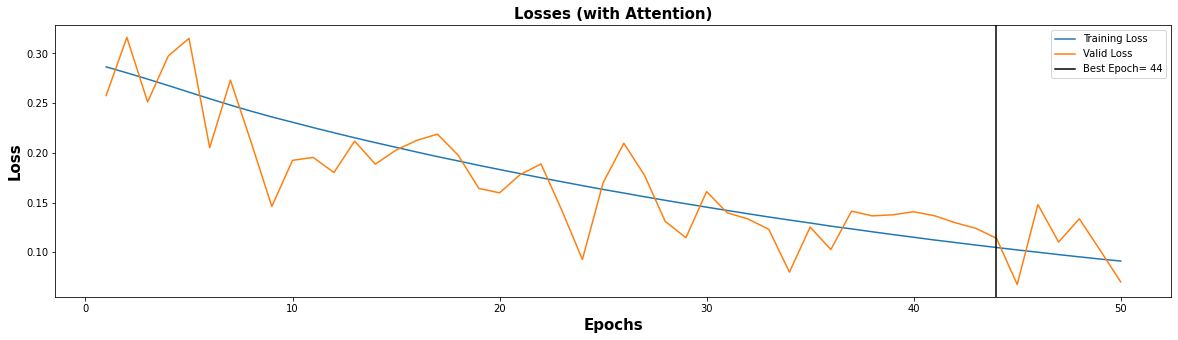

In [48]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

plt.plot(x,train_losses)
plt.plot(x,valid_losses)
plt.axvline(best_epoch, color='black')
plt.xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.title("Losses (with Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch}"])
plt.savefig(f"Losses {movie}_{score}_att.png",facecolor='white');

### Training without Attention Layer

In [49]:
model     = GRU_RNN(input_dim, output_dim, hidden_dim, seq_length, n_layers,att=False)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
print(model)

GRU_RNN(
  (gru): GRU(300, 32, num_layers=2, batch_first=True, dropout=1e-06)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (func): Softmax(dim=-1)
)


In [50]:
train_losses_1,valid_losses_1,tr_acc_1,val_acc_1,best_epoch = train(epochs,train_loader,model,valid_loader,optimizer,criterion,att=False)

Validation loss decreased (inf --> 0.167020).  Saving model ...
Epoch: 1/50 	Training Loss: 0.323667 	Validation Loss: 0.167020
Validation loss decreased (0.167020 --> 0.099445).  Saving model ...
Epoch: 2/50 	Training Loss: 0.159237 	Validation Loss: 0.099445
Validation loss decreased (0.099445 --> 0.063748).  Saving model ...
Epoch: 3/50 	Training Loss: 0.081085 	Validation Loss: 0.063748
Epoch: 4/50 	Training Loss: 0.057170 	Validation Loss: 0.072026
Epoch: 5/50 	Training Loss: 0.050083 	Validation Loss: 0.067528
Epoch: 6/50 	Training Loss: 0.040832 	Validation Loss: 0.068751
Validation loss decreased (0.063748 --> 0.031609).  Saving model ...
Epoch: 7/50 	Training Loss: 0.034273 	Validation Loss: 0.031609
Epoch: 8/50 	Training Loss: 0.031803 	Validation Loss: 0.051059
Epoch: 9/50 	Training Loss: 0.029840 	Validation Loss: 0.067352
Epoch: 10/50 	Training Loss: 0.027361 	Validation Loss: 0.049163
Epoch: 11/50 	Training Loss: 0.025961 	Validation Loss: 0.063297
Epoch: 12/50 	Training 

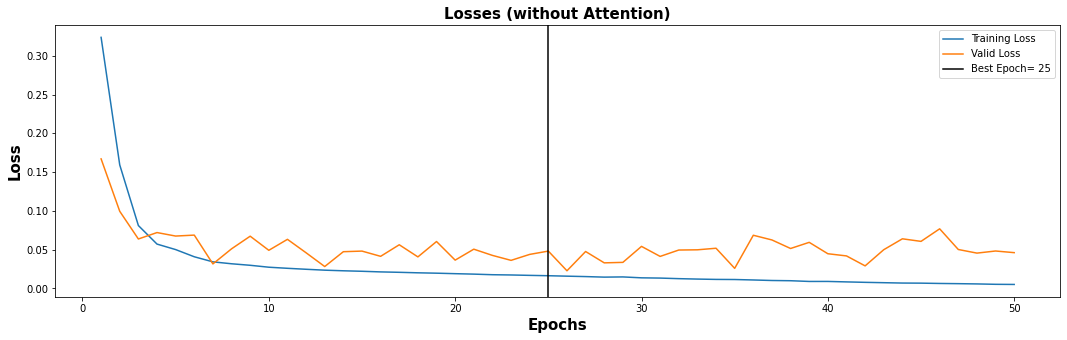

In [51]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(5)

plt.plot(x,train_losses_1)
plt.plot(x,valid_losses_1)
plt.axvline(best_epoch, color='black')
plt.xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.title(f"Losses (without Attention)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch}"])
plt.savefig(f"Losses {movie}_{score}.png",facecolor='white');

## Testing

In [21]:
def test(test_loader,net):
    v_c = 0
    net.to(device)
    net.eval()
    num_correct = 0
    valid_acc = 0
    out  = []
    l_all =[]
    h = net.init_hidden(batch_size)
    f = True
    for inputs, labels in test_loader:
        v_c += 1
        if (v_c == 8):#12, #6, #8
            continue
        h = h.data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #l_all.append(labels.cpu().detach().numpy())
        output, h = net(inputs, h)
        #print(output,labels)
        #print(labels)
        #pred = torch.round(output.squeeze()) 
        output = output.view(batch_size,-1)
        print(output.shape,labels.shape)
        output = output.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        if f:
            out  = output
            l_all = labels
            f = False
        else:
            out = np.concatenate((out,output), axis=0)
            l_all = np.concatenate((l_all,labels),axis=0)
    return out,l_all

In [22]:
def get_scores(opt,lbl):
    co = []
    po = []
    for i in range(lbl.shape[1]):
        z = []
        m = []
        for j in range(lbl.shape[0]):
            z.append(opt[j][i])
            m.append(lbl[j][i])
        coef, p = spearmanr(z,m)
        co.append(coef)
        po.append(p)
    return co,po

In [23]:
#xa = DataLoader(ConcatDataset([train_data,test_data]),batch_size=batch_size)
#xa = test_loader
xa = [d for dl in [valid_loader, test_loader] for d in dl]

### Prediction with Attention Layer

In [24]:
model = GRU_RNN(input_dim, output_dim, hidden_dim, seq_length, n_layers)
model.load_state_dict(torch.load('RNN_GRU_Att.pt'))

<All keys matched successfully>

In [25]:
out,l_all = test(xa,model)

torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])


In [26]:
coef, p_val = get_scores(out,l_all)

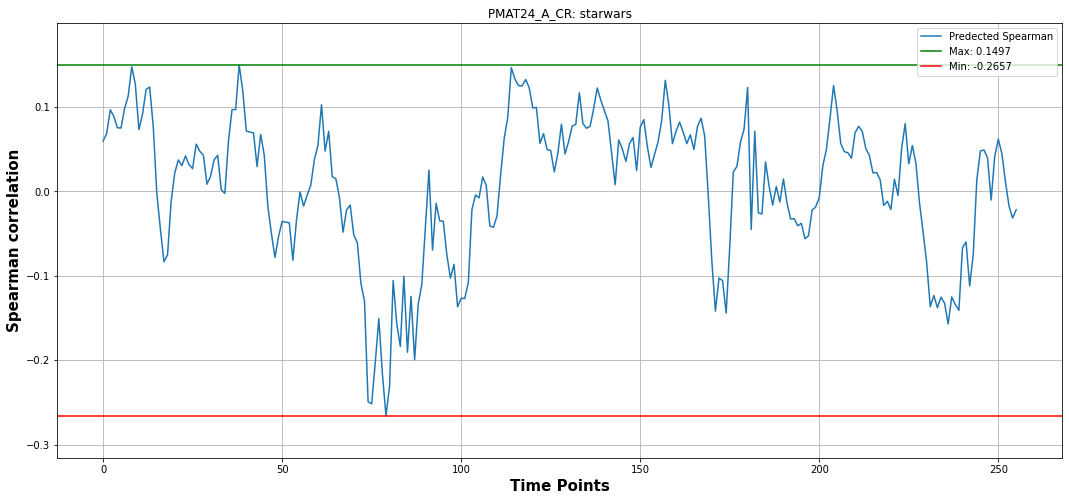

In [27]:
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(8)
plt.plot([x for x in range(seq_length)],coef);
#plt.plot([x for x in range(seq_length)],coef1);
plt.axhline(y = max(coef), color = 'g', linestyle = '-')
plt.axhline(y = min(coef), color = 'r', linestyle = '-')
plt.ylim([min(coef)-0.05, max(coef)+0.05])
plt.grid()
plt.title(f"{score}: {movie}")
plt.xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Spearman correlation",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Predected Spearman",f"Max: {round(max(coef),4)}",f"Min: {round(min(coef),4)}"])

plt.savefig(f"Spearman {movie}_{score}_att_{shuffle}.png",facecolor='white');

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)
plt.plot([x for x in range(seq_length)],coef);
plt.axhline(y = max(coef), color = 'g', linestyle = '-')
plt.axhline(y = min(coef), color = 'r', linestyle = '-')
plt.ylim(max(coef), min(coef));

### Prediction without Attention Layer

In [28]:
model = GRU_RNN(input_dim, output_dim, hidden_dim, seq_length, n_layers,att=False)
model.load_state_dict(torch.load('RNN_GRU.pt'))

<All keys matched successfully>

In [29]:
out_1,l_all_1 = test(xa,model)

torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])
torch.Size([15, 256]) torch.Size([15, 256])


In [30]:
coef_1, p_val_1 = get_scores(out_1,l_all_1)

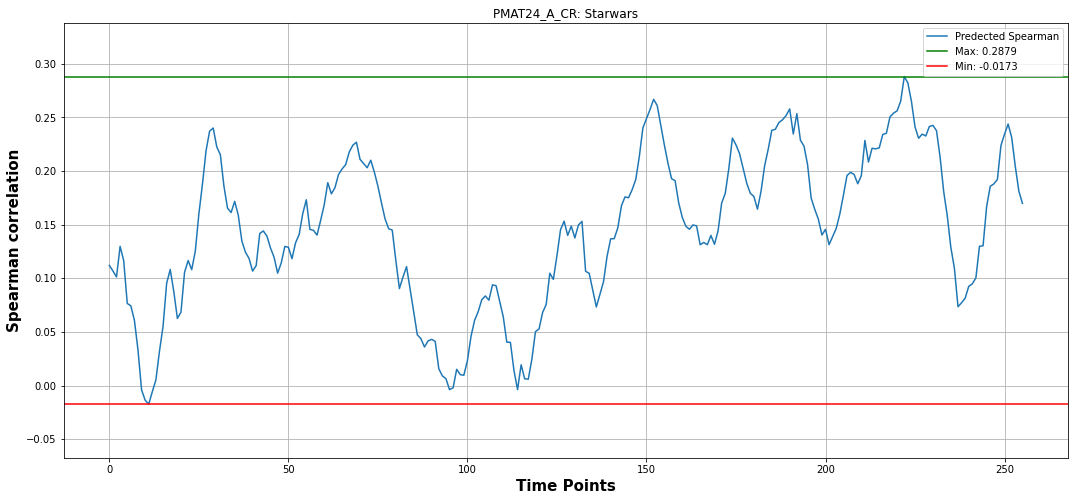

In [31]:
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(8)
plt.plot([x for x in range(seq_length)],coef_1);
plt.axhline(y = max(coef_1), color = 'g', linestyle = '-')
plt.axhline(y = min(coef_1), color = 'r', linestyle = '-')
plt.ylim([min(coef_1)-0.05, max(coef_1)+0.05])
plt.title(f"{score}: {movie.capitalize()}")
plt.xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.ylabel("Spearman correlation",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
plt.legend(["Predected Spearman",f"Max: {round(max(coef),4)}",f"Min: {round(min(coef),4)}"])
plt.grid()
plt.legend(["Predected Spearman",f"Max: {round(max(coef_1),4)}",f"Min: {round(min(coef_1),4)}"])
plt.savefig(f"Spearman {movie}_{score}_{shuffle}.png",facecolor='white');

## Results

### Spearman Correlation Rank

#### Starwars || Verbal IQ
<h3><center> Attention Model </center></h3>
<img src="Spearman starwars_PicVocab_Unadj_att_False.png">
<h3><center> Model in Paper</center></h3>
<img src="Spearman starwars_PicVocab_Unadj_False.png">

---

#### Starwars || Fluid Intelligence
<h3> <center> Attention Model </center></h3>
<img src="Spearman starwars_PMAT24_A_CR_att_False.png">
<h3><center> Model in Paper</center></h3>
<img src="Spearman starwars_PMAT24_A_CR_False.png">

### Losses

#### Starwars || Verbal IQ
<h3><center> Attention Model </center></h3>
<img src="Losses starwars_PicVocab_Unadj_att.png">
<h3><center> Model in Paper</center></h3>
<img src="Losses starwars_PicVocab_Unadj.png">

#### Starwars || Fluid Intelligence
<h3> <center> Attention Model </center></h3>
<img src="Losses starwars_PMAT24_A_CR_att.png">
<h3><center> Model in Paper</center></h3>
<img src="Losses starwars_PMAT24_A_CR.png">